# Compare predictive performance across endpoint categories

How does predictive performance compare across endpoint types?

In [4]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings

## Input annotations

In [5]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type"),
    (pl.col("Metadata_Count_1")/pl.col("Total_Compounds")).alias("Percent_Positive"),
)

pred_pandas = pred_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)


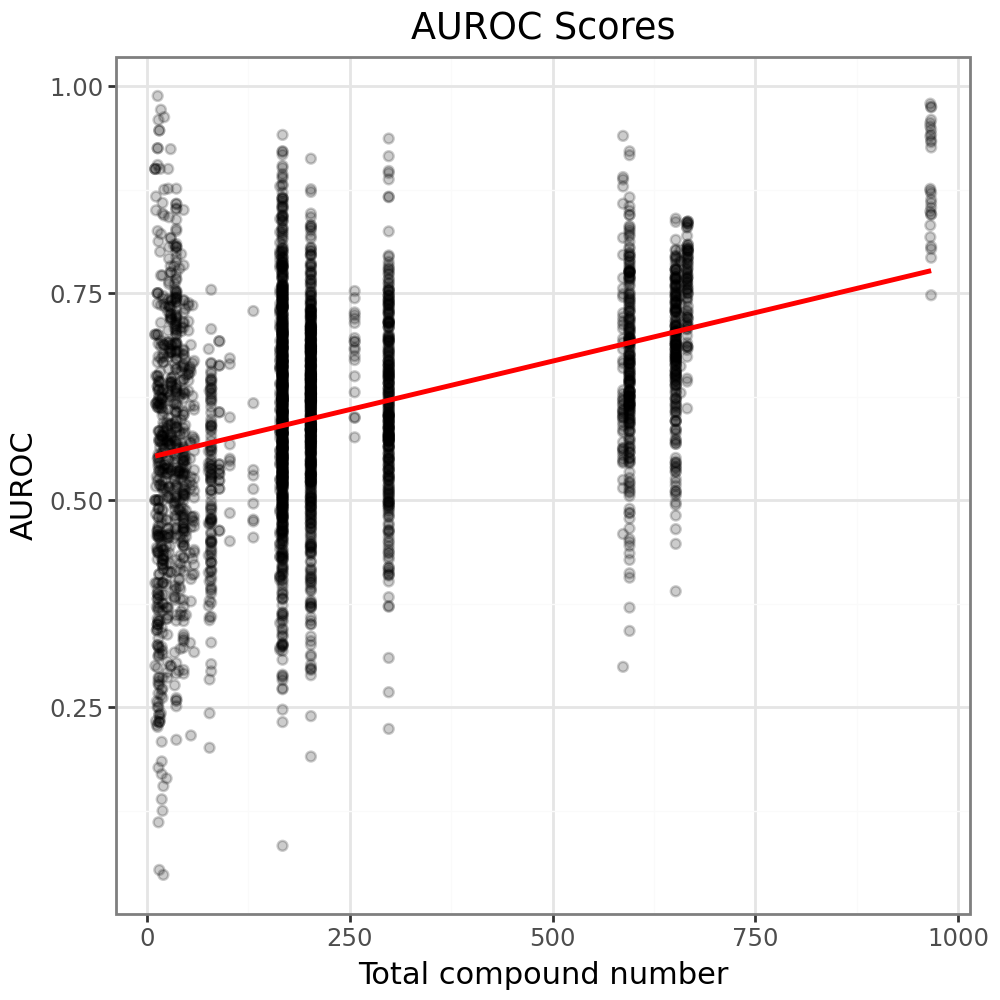

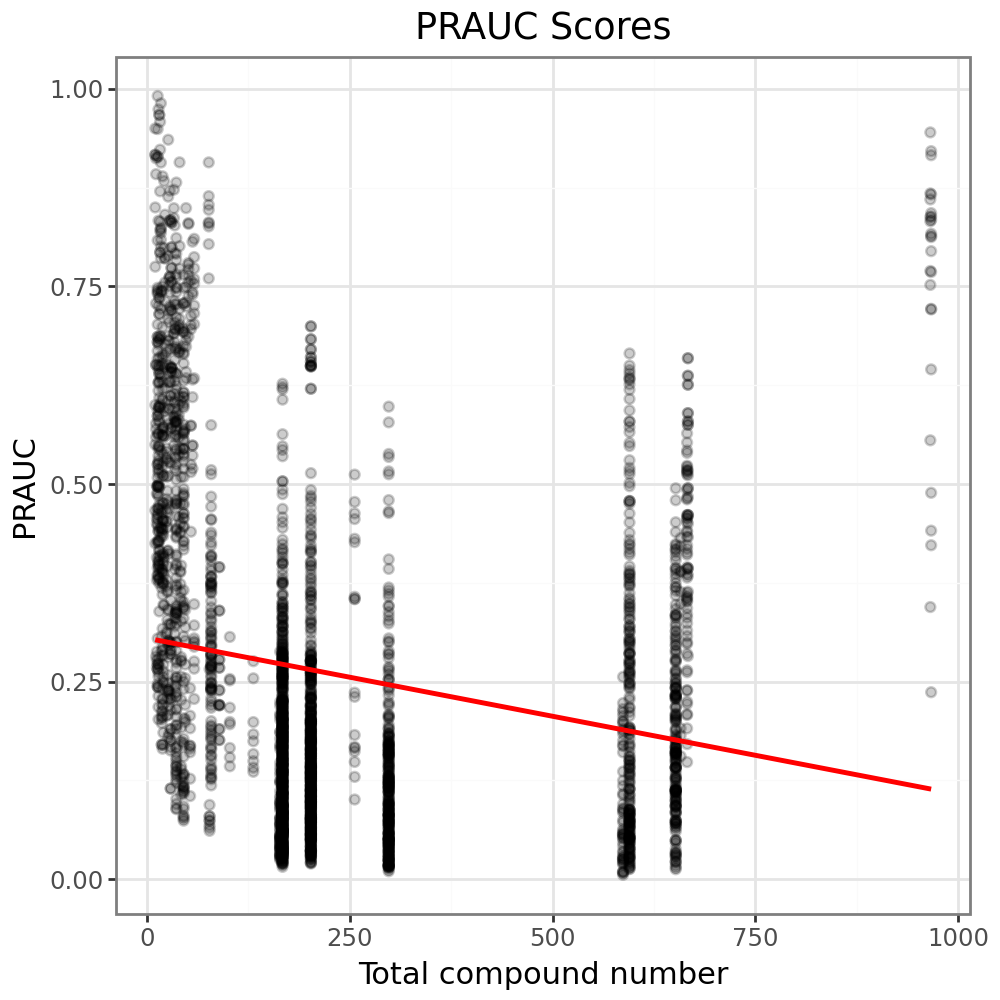

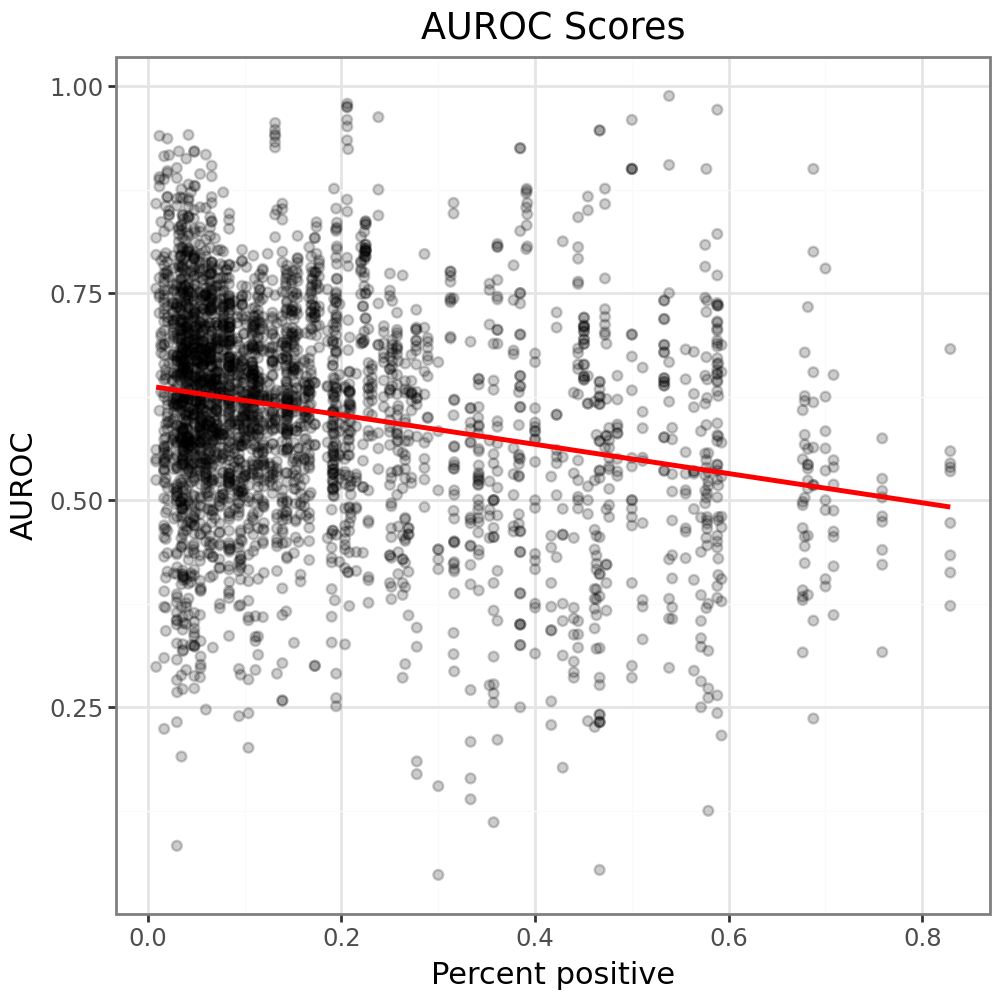

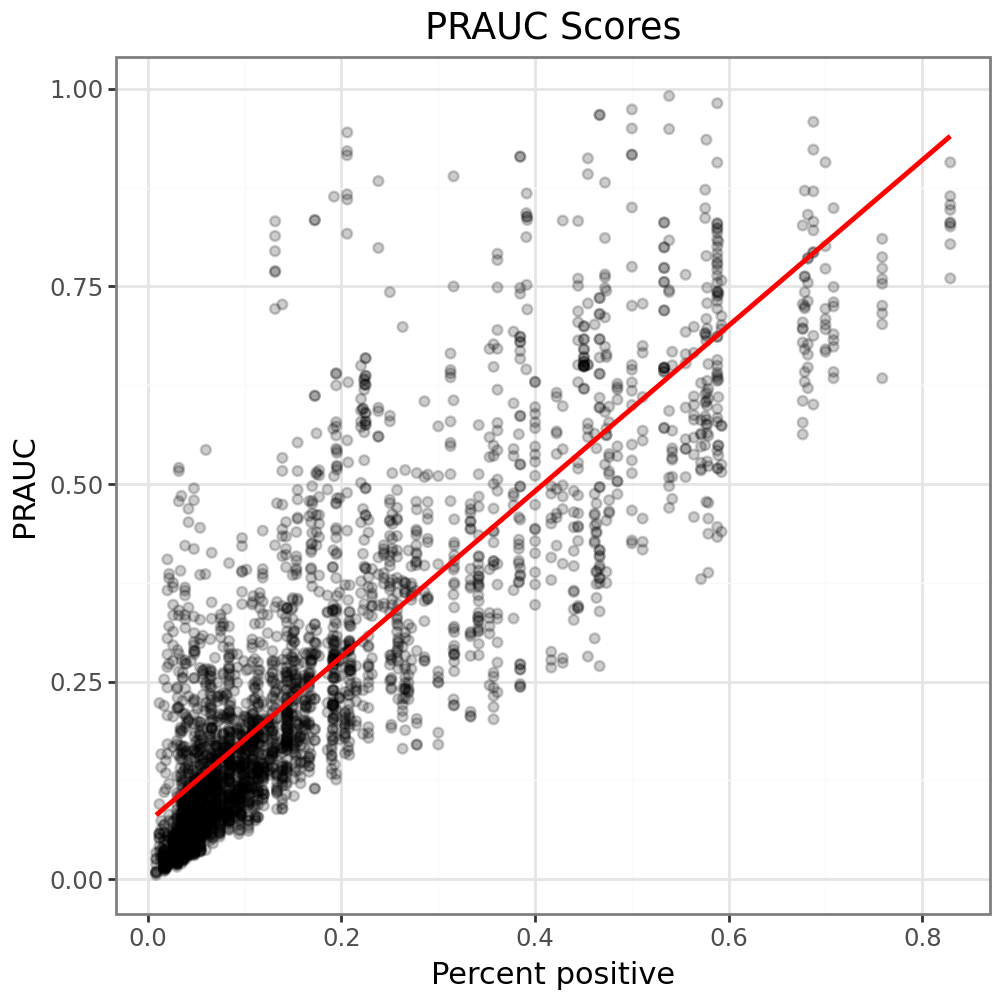

In [18]:
from plotnine import geom_point, ggplot, aes, labs, theme_bw, facet_wrap, geom_smooth

pn.options.figure_size = (5, 5)

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Total_Compounds', y='AUROC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='AUROC Scores', x='Total compound number', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Total_Compounds', y='PRAUC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='PRAUC Scores', x='Total compound number', y='PRAUC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Percent_Positive', y='AUROC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='AUROC Scores', x='Percent positive', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Percent_Positive', y='PRAUC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='PRAUC Scores', x='Percent positive', y='PRAUC') 
    + theme_bw()
)
plot.show()

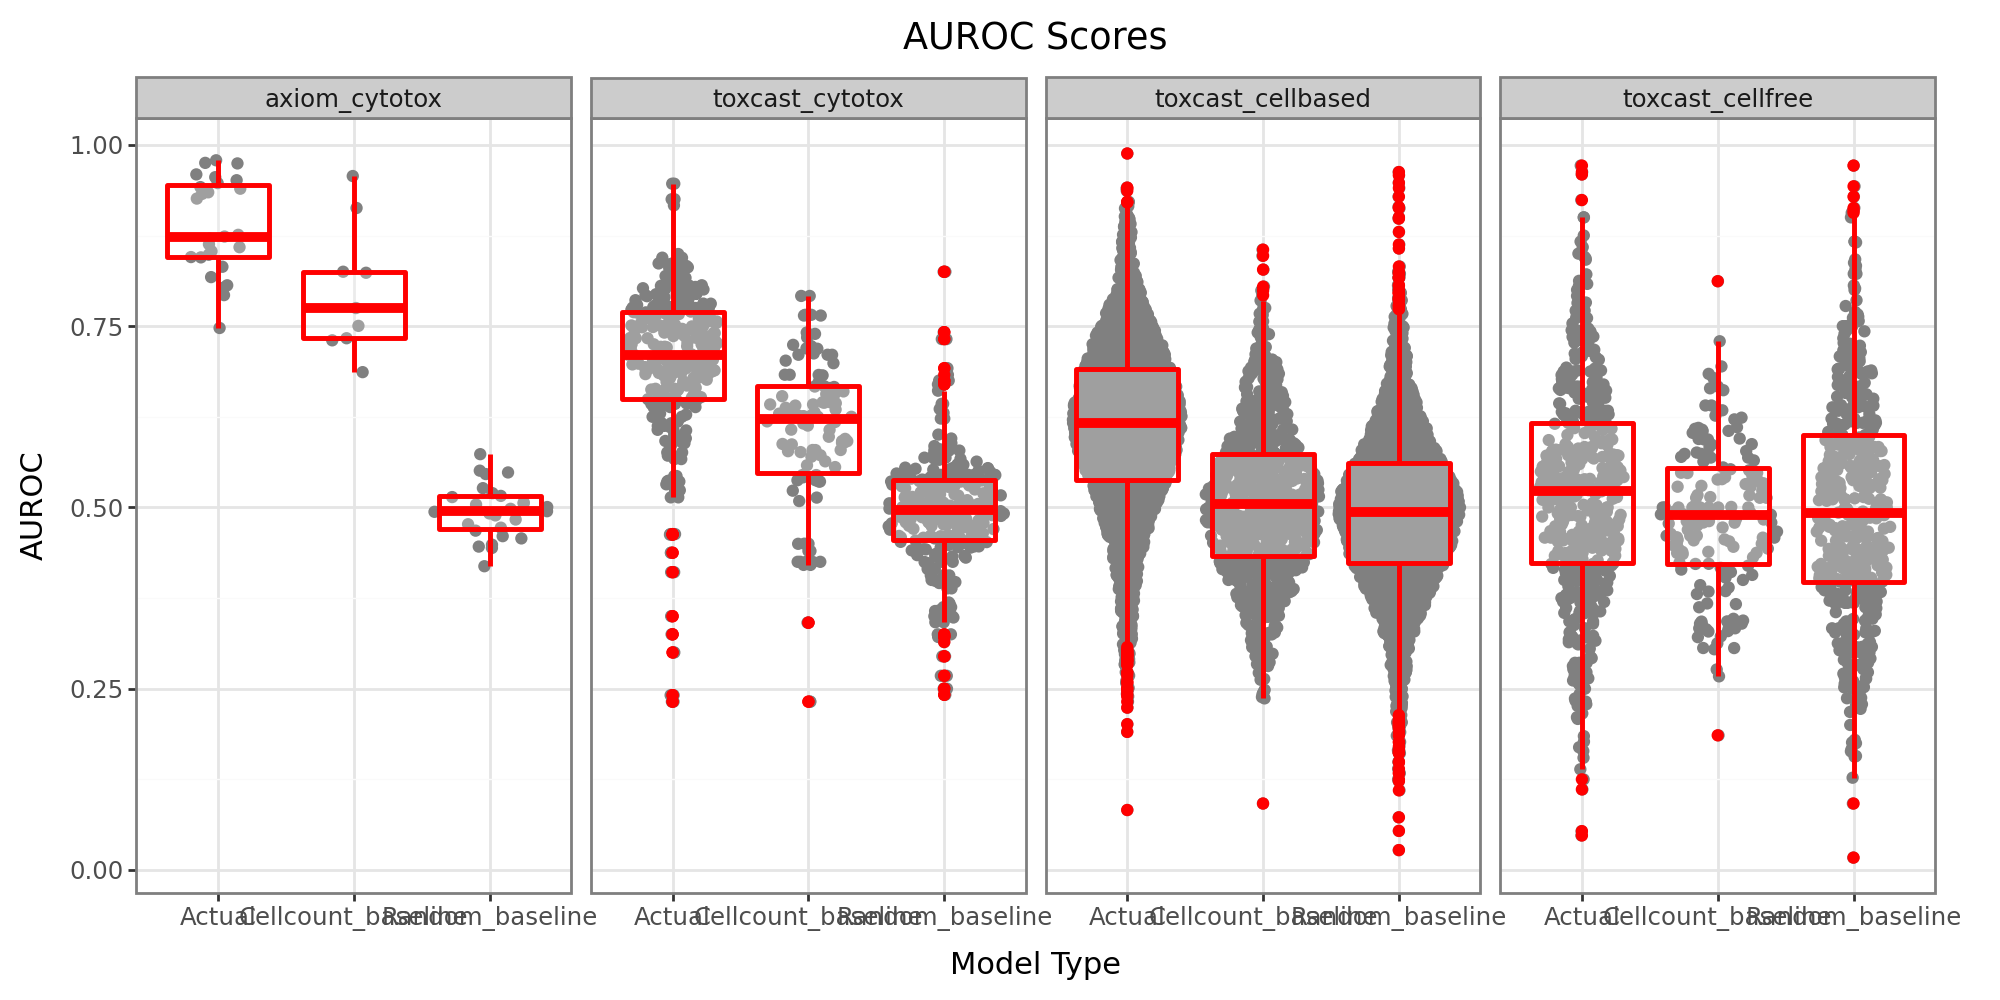

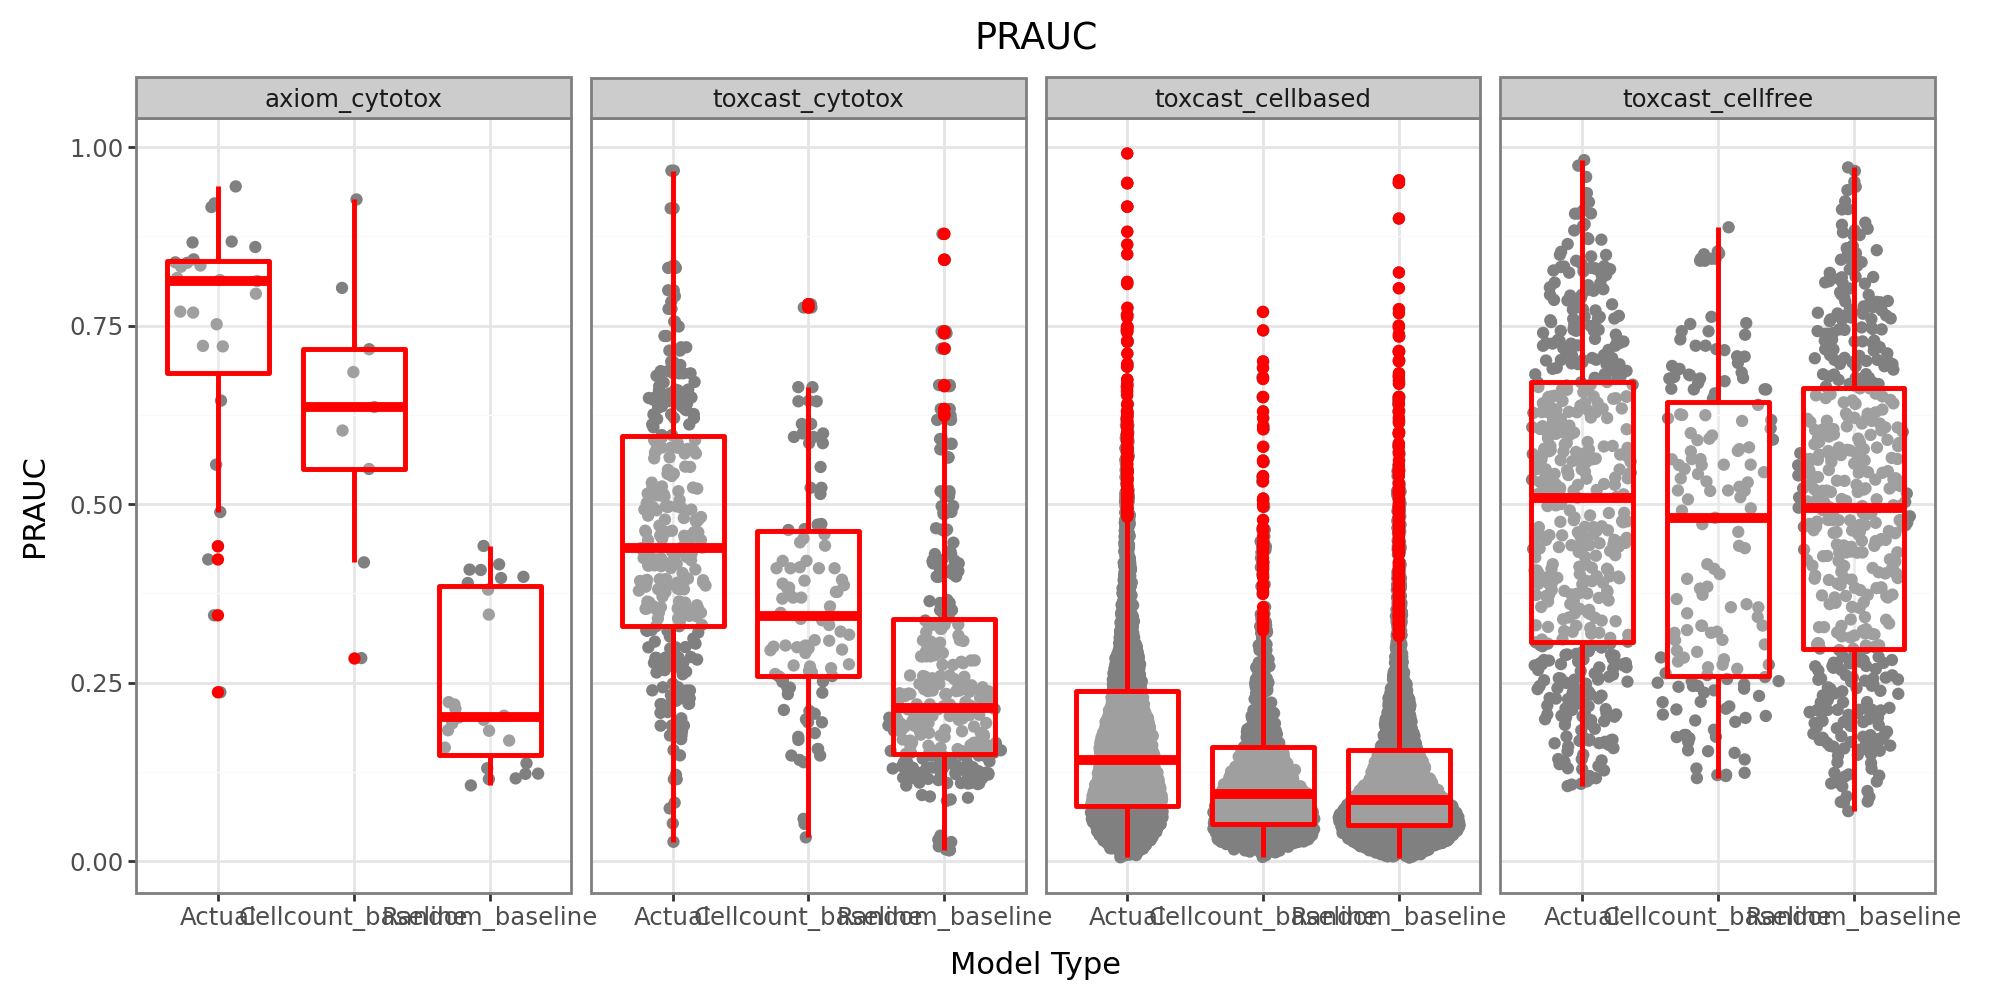

In [6]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='AUROC Scores', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='PRAUC', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

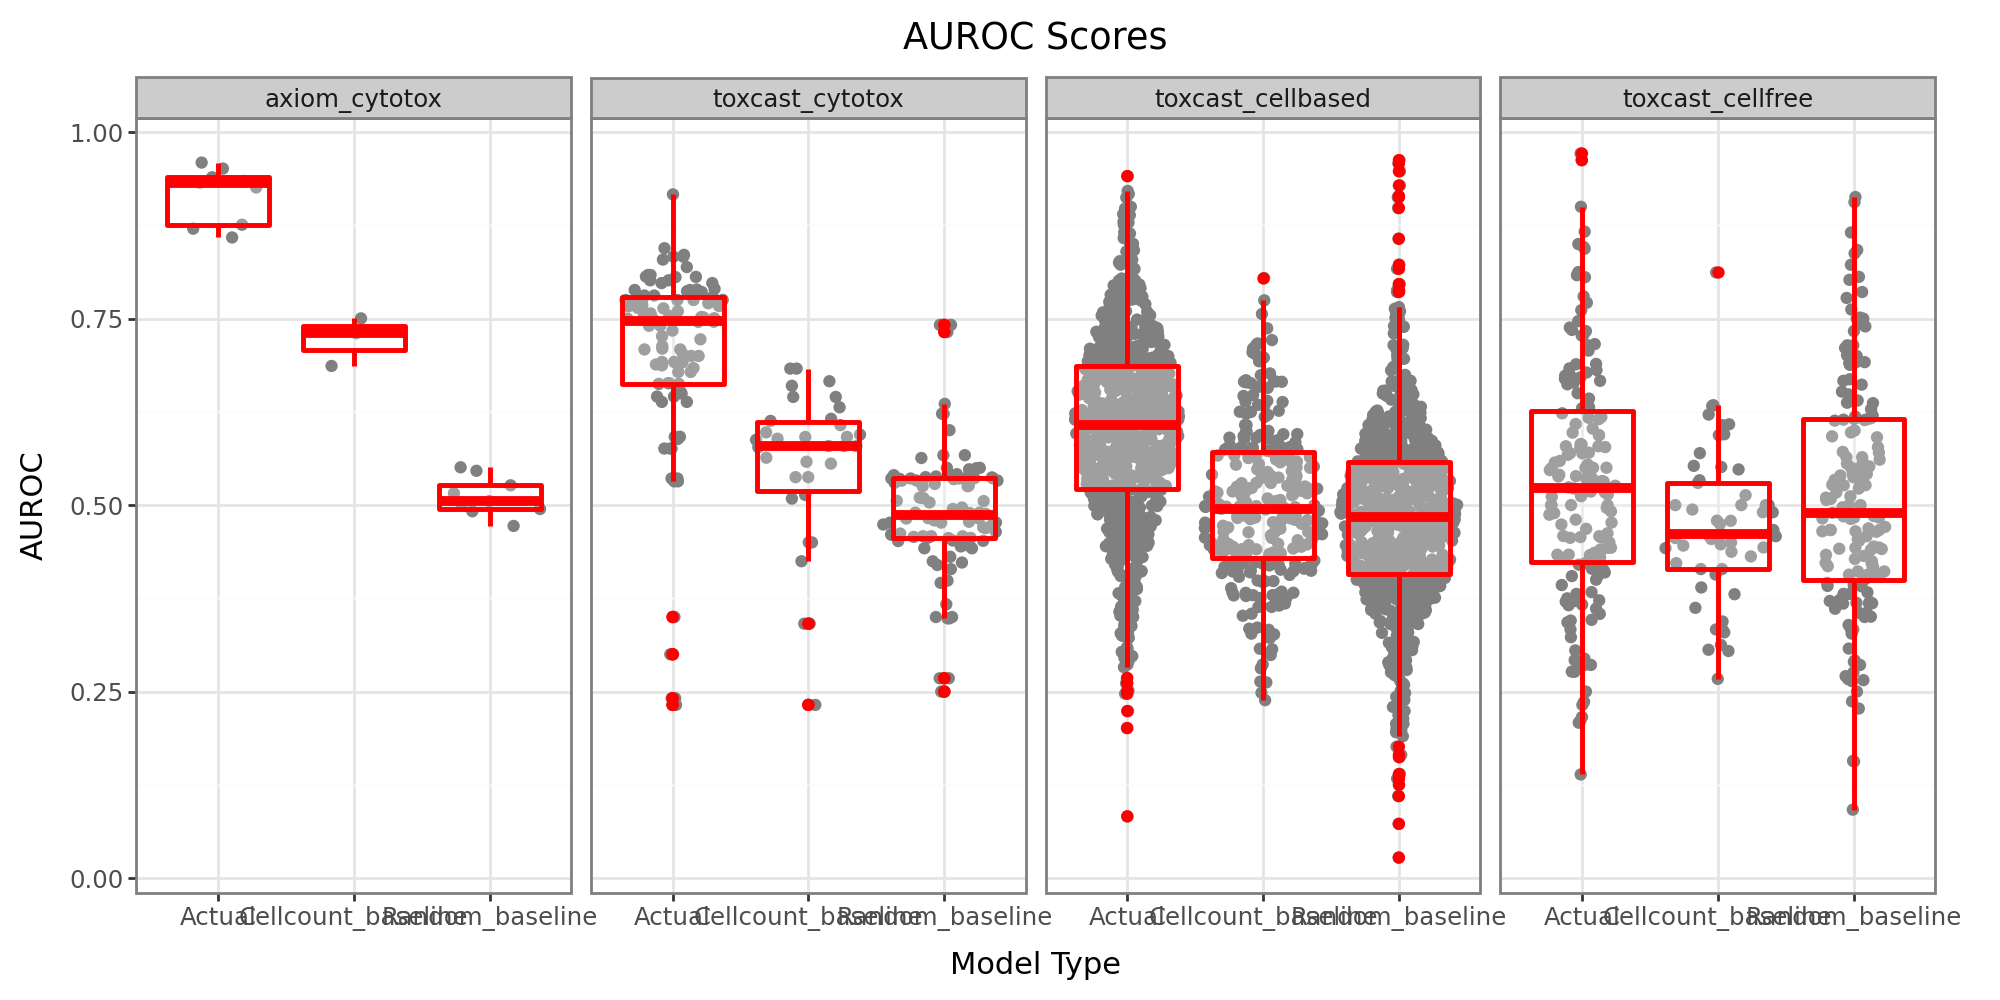

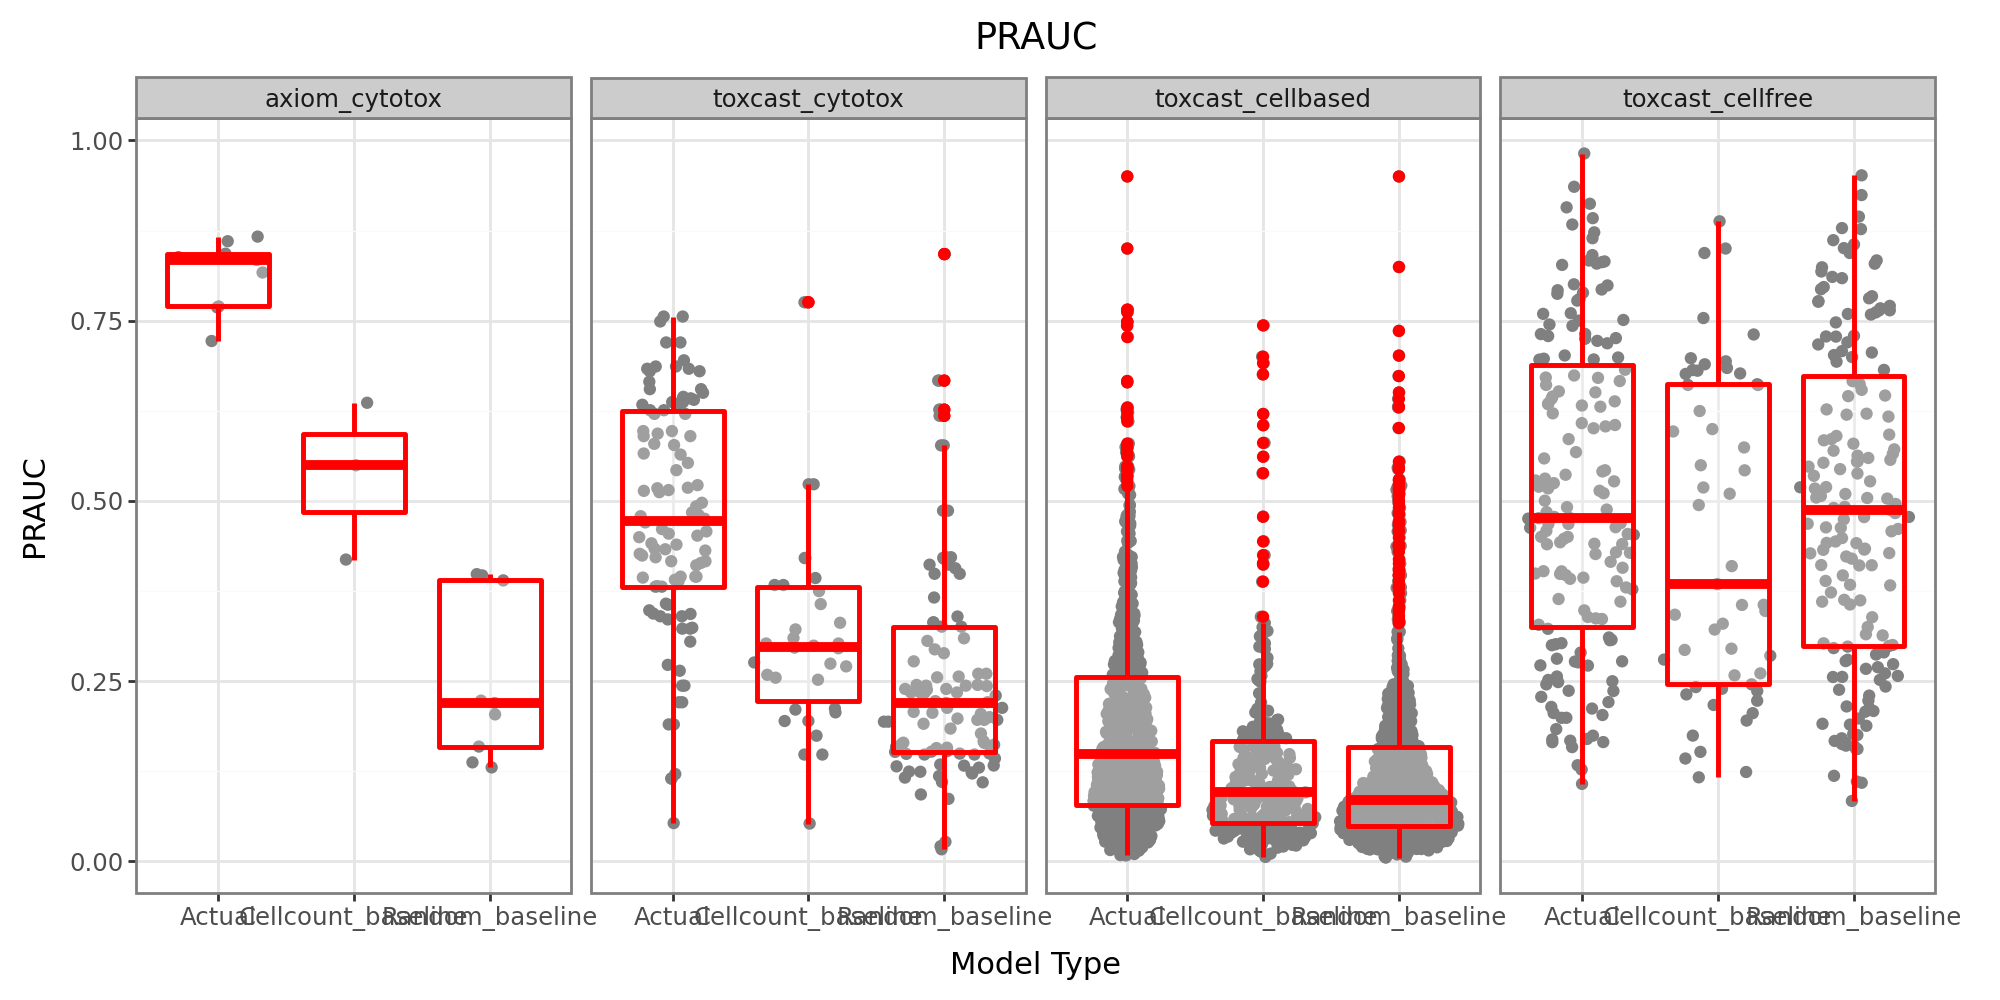

In [12]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pred_pandas = pred_df.filter(pl.col("Metadata_AggType") == "all").to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

pn.options.figure_size = (10, 5)

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='AUROC Scores', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='PRAUC', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [4]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Model_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type+Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Model_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.3924   0.0 -0.4064 -0.3784   True
------------------------------------------------------------
P-values: [6.99440506e-15]
Processing Endpoint_type: toxcast_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1      group2     meandiff p-adj lower   upper  reject
-----------------------------------------------------------
Actual Random_baseline  -0.1996   0.0 -0.206 -0.1933   True
-----------------------------------------------------------
P-values: [1.51656465e-13]
Processing Endpoint_type: toxcast_cellbased
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.1164 

In [49]:
warnings.filterwarnings("ignore")

prauc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Model_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type+Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Model_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    prauc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.4847   0.0 -0.5487 -0.4208   True
------------------------------------------------------------
P-values: [6.99440506e-15]
Processing Endpoint_type: toxcast_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1      group2     meandiff p-adj  lower  upper  reject
-----------------------------------------------------------
Actual Random_baseline  -0.1859   0.0 -0.2088 -0.163   True
-----------------------------------------------------------
P-values: [1.51656465e-13]
Processing Endpoint_type: toxcast_cellbased
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.0514 

## Redo after filtering by compound number

In [19]:
pred_df = pred_df.filter(pl.col("Total_Compounds") >= 100)
pred_pandas = pred_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

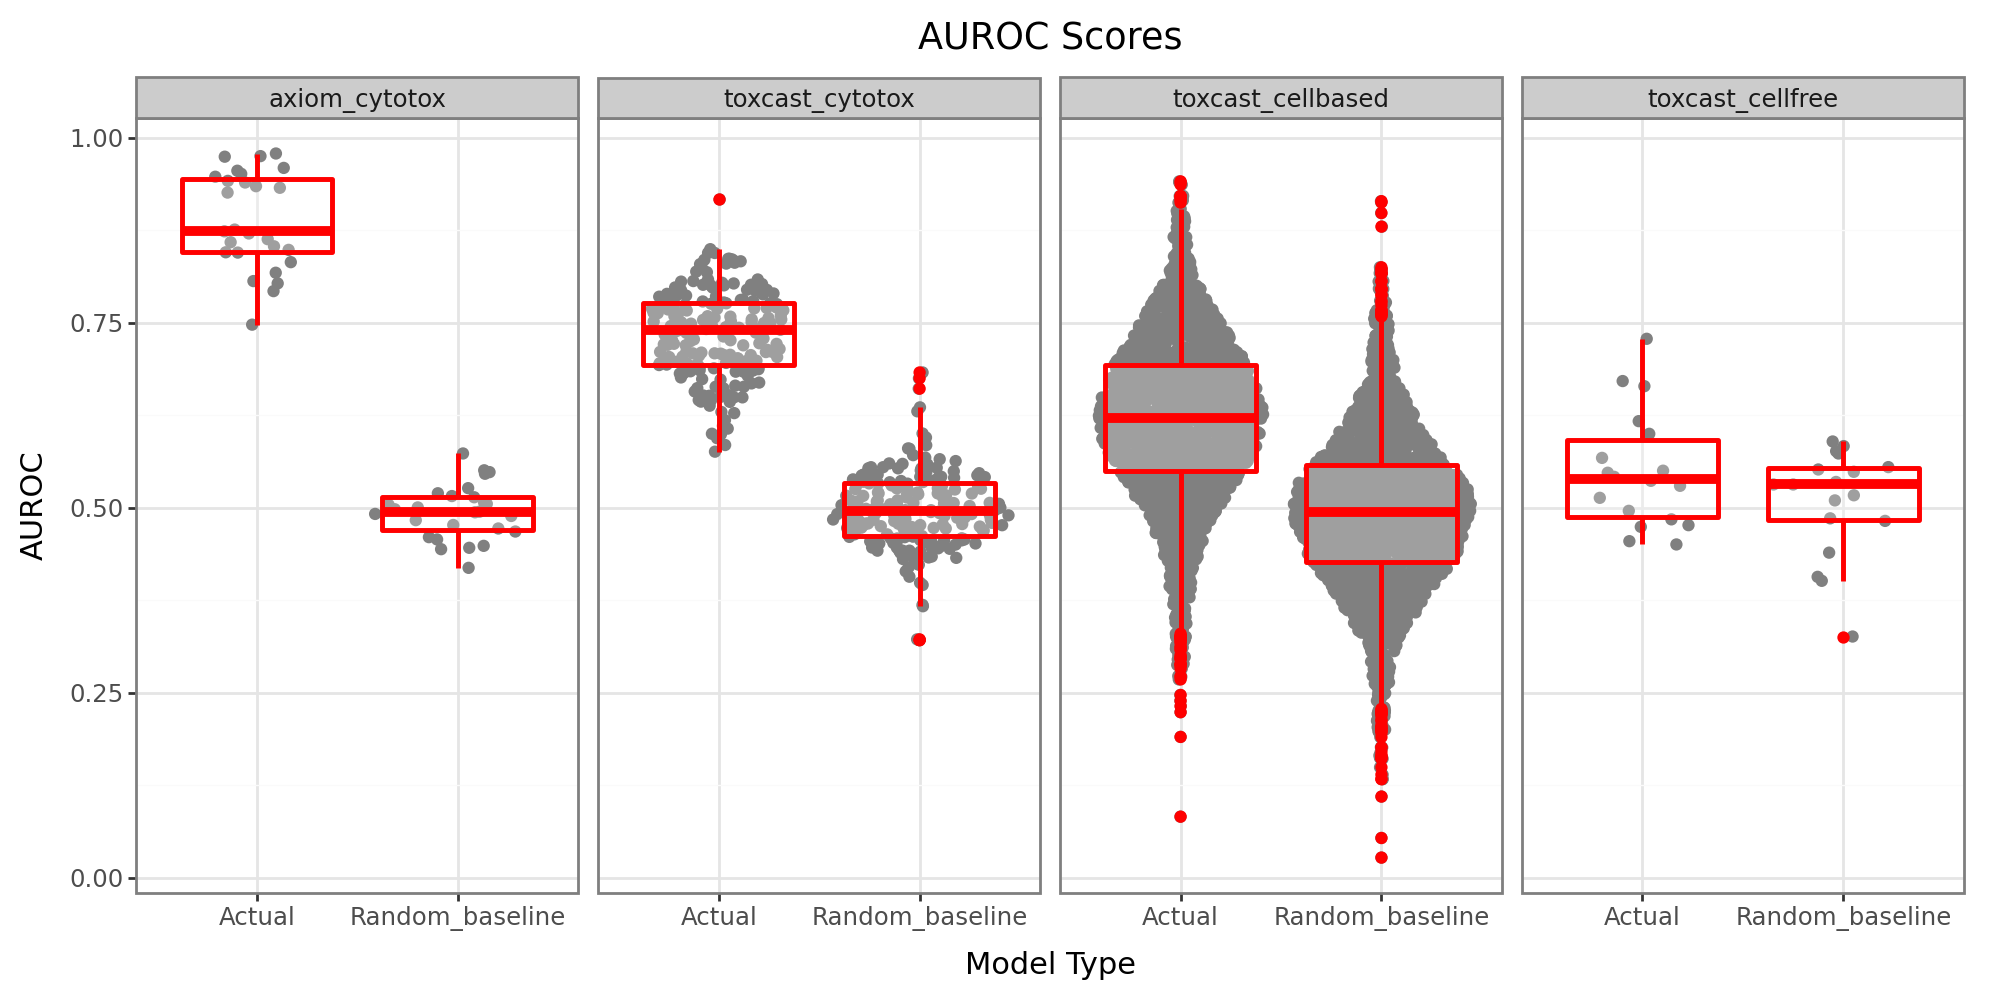

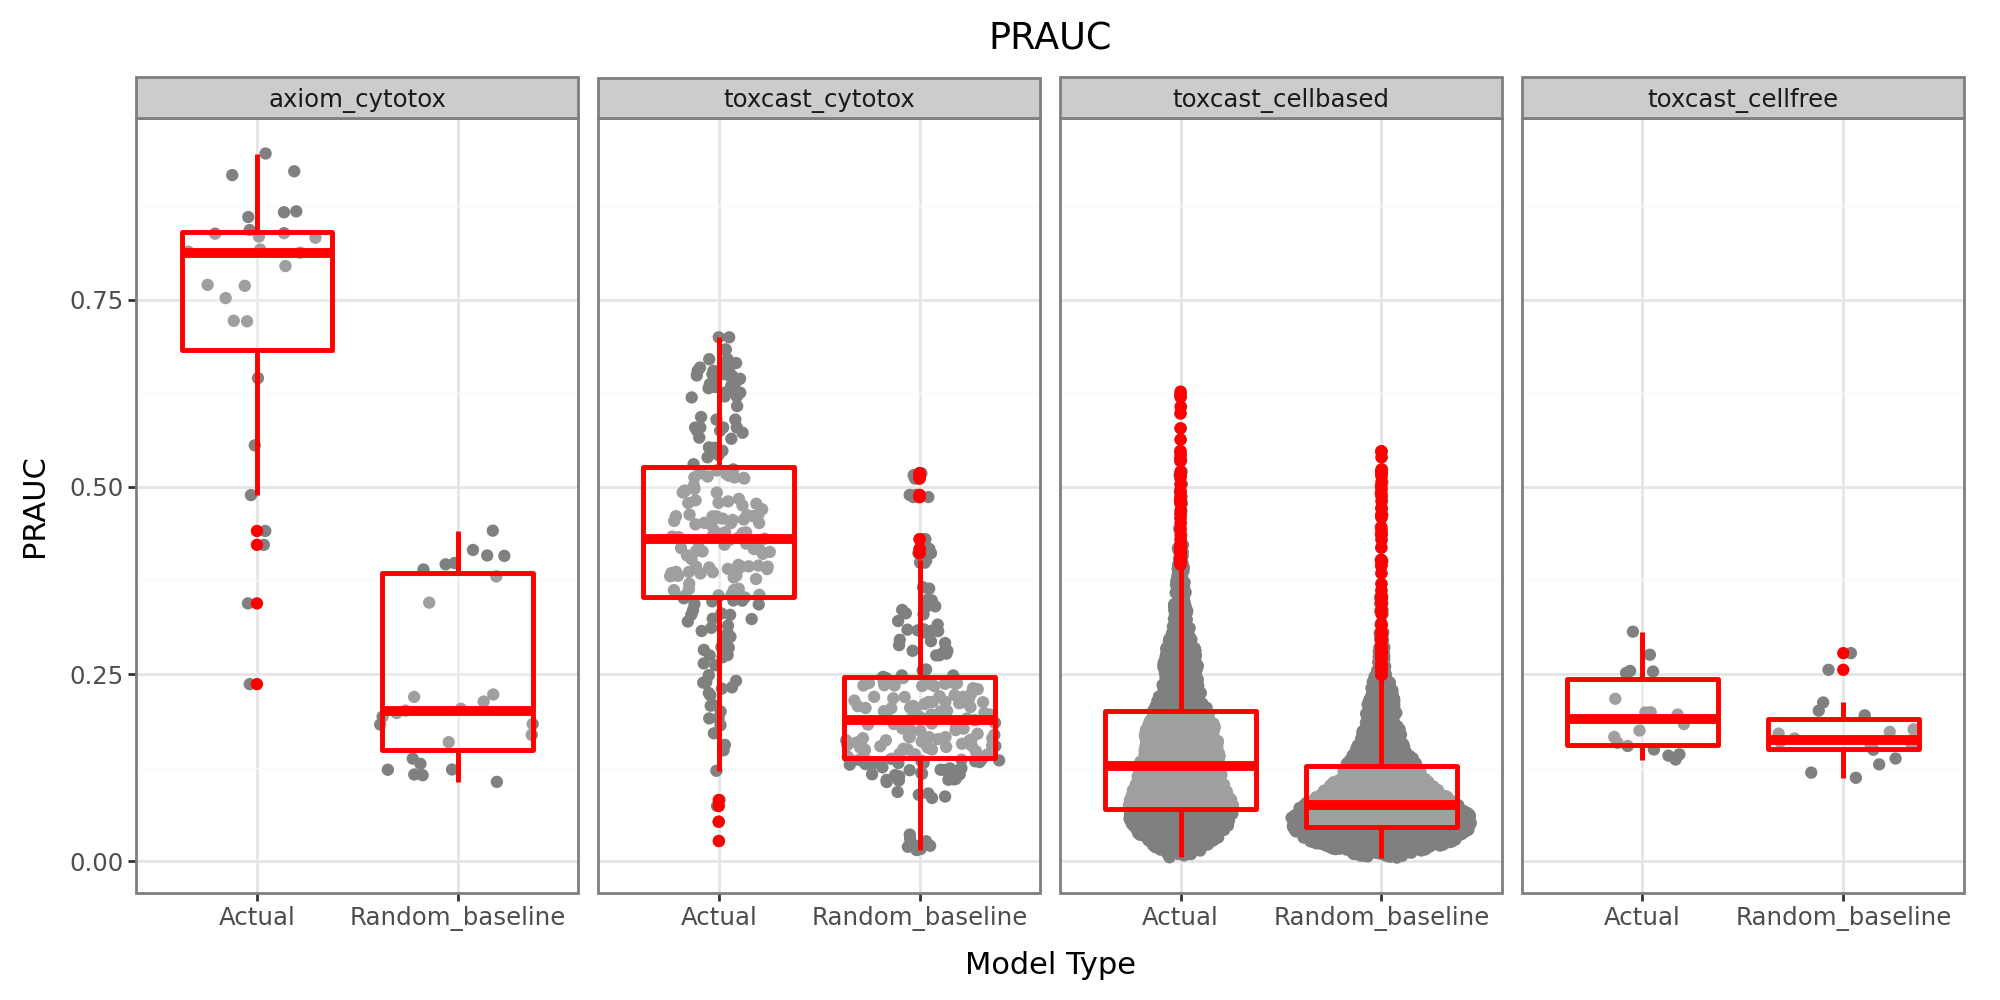

In [7]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='AUROC Scores', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='PRAUC', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

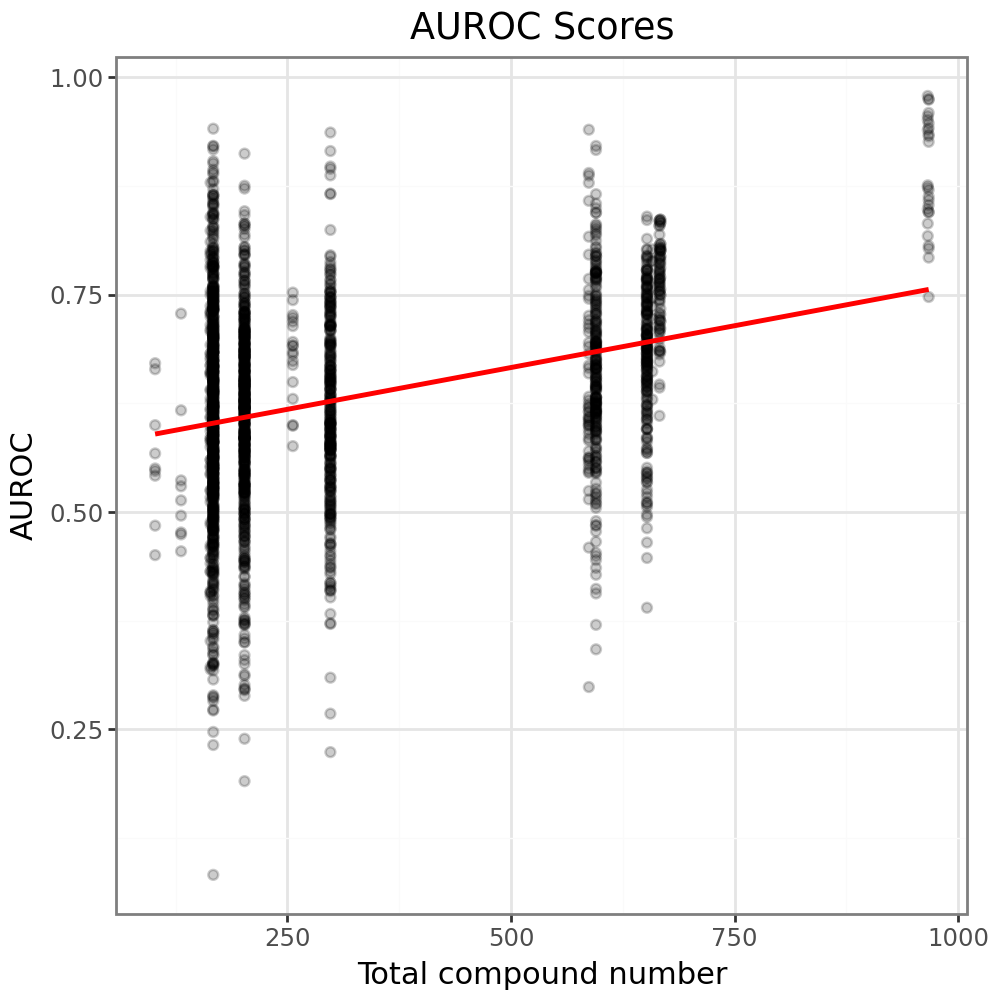

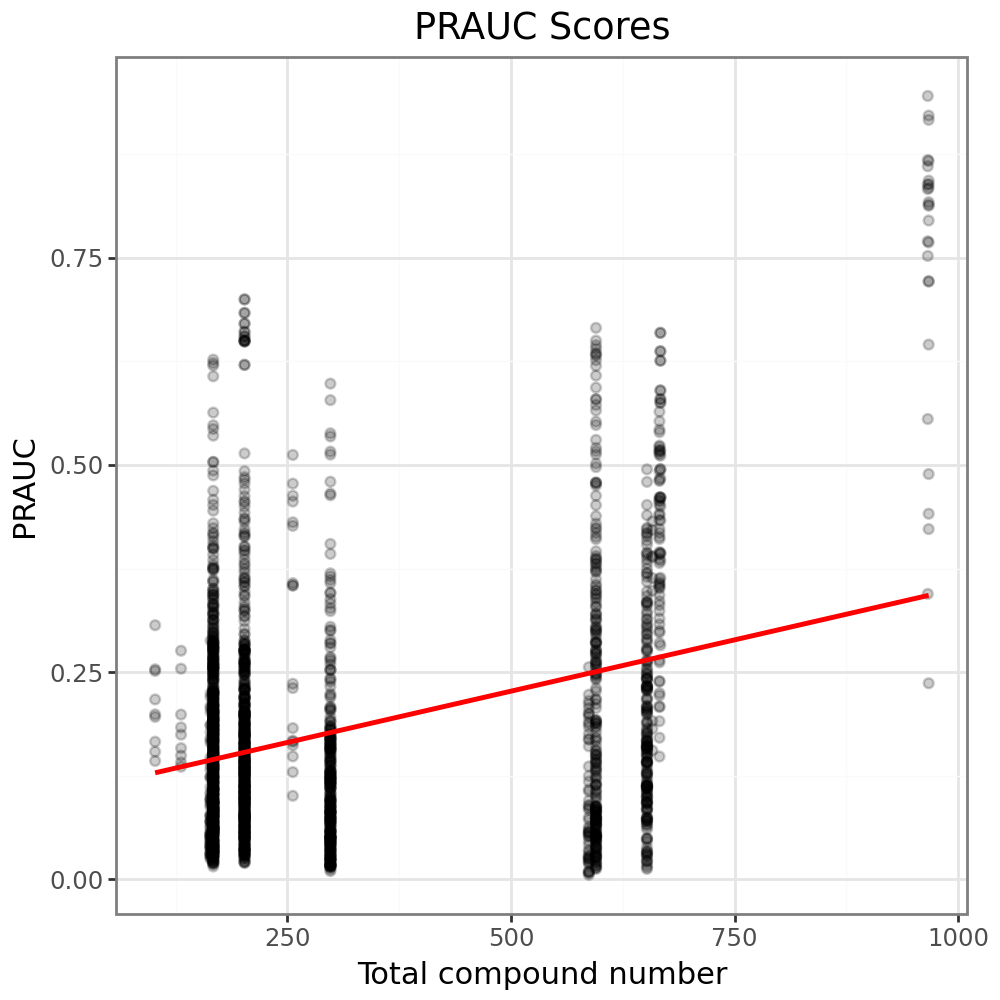

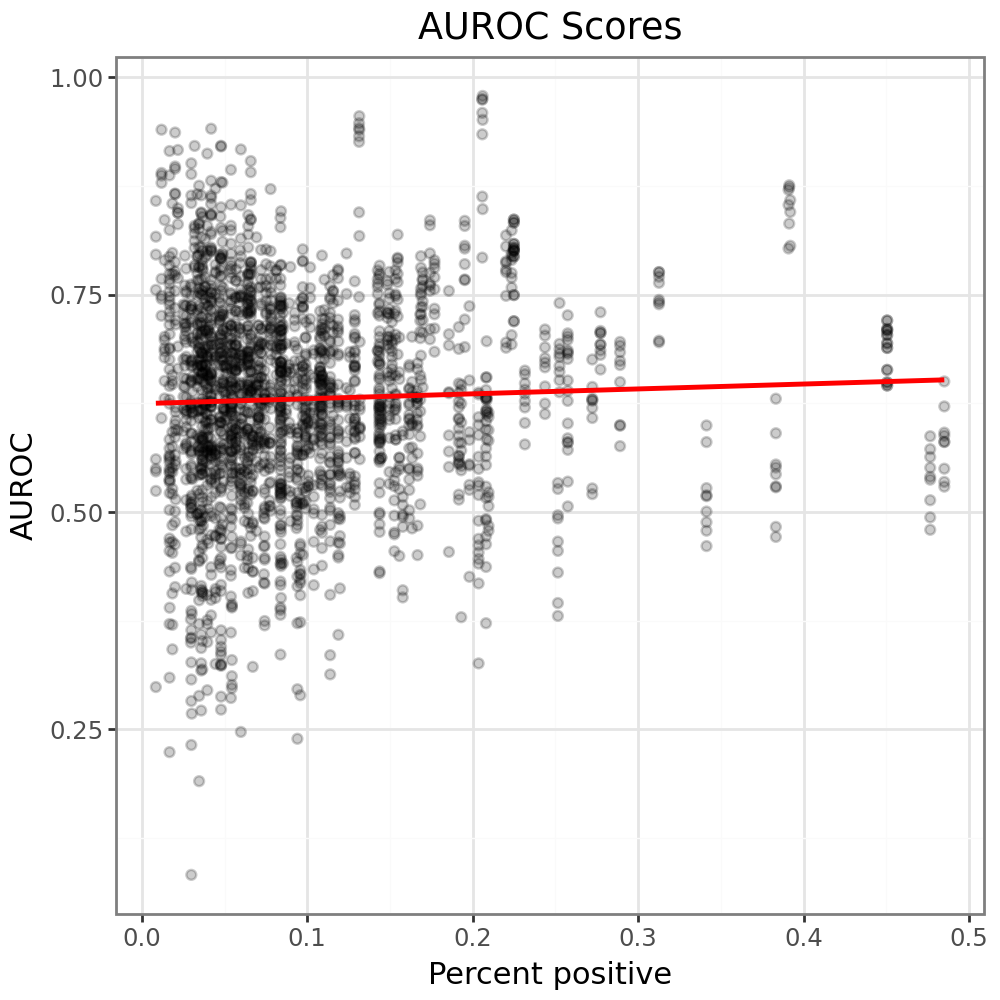

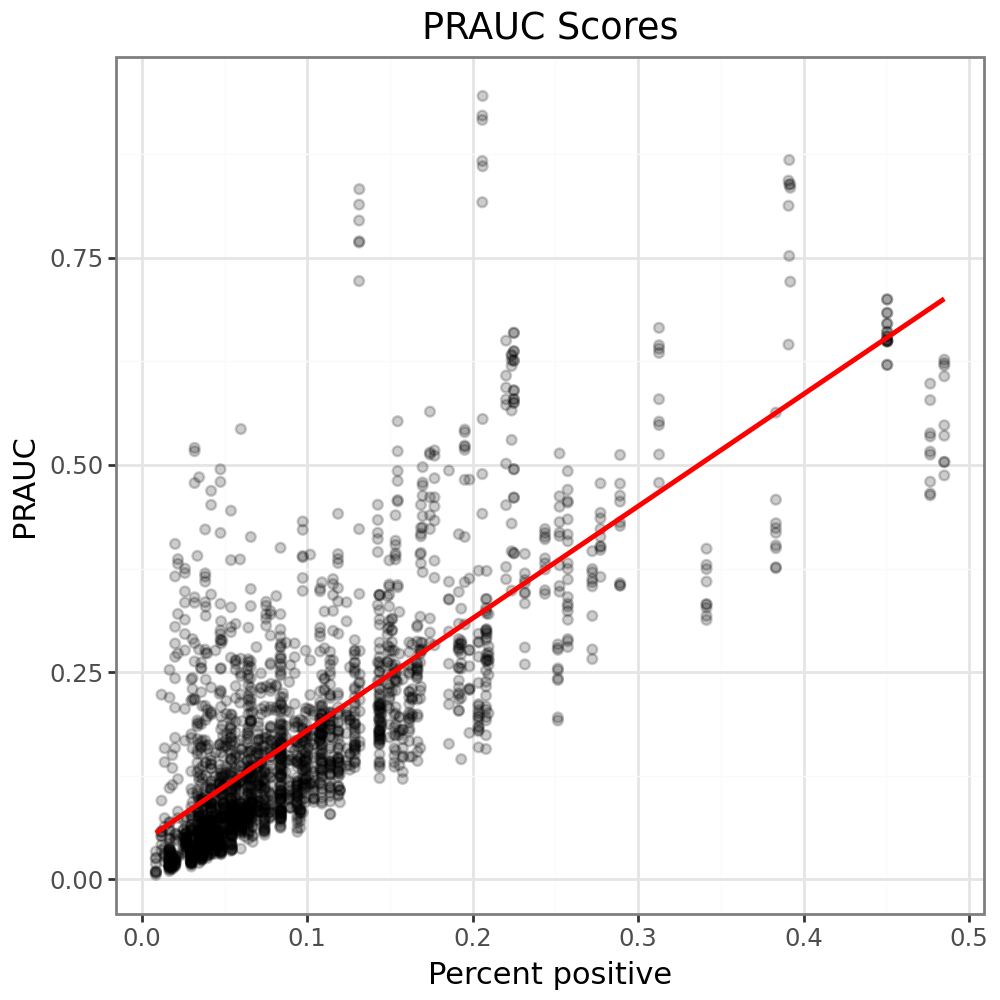

In [20]:
from plotnine import geom_point, ggplot, aes, labs, theme_bw, facet_wrap

pn.options.figure_size = (5, 5)

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Total_Compounds', y='AUROC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='AUROC Scores', x='Total compound number', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Total_Compounds', y='PRAUC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='PRAUC Scores', x='Total compound number', y='PRAUC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Percent_Positive', y='AUROC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='AUROC Scores', x='Percent positive', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas[pred_pandas["Model_type"] == "Actual"], aes(x='Percent_Positive', y='PRAUC')) 
    + geom_point(alpha=0.2) 
    + geom_smooth(method='lm', color='red', se=False)
    + labs(title='PRAUC Scores', x='Percent positive', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [15]:
pred_df

Metadata_AggType,Metadata_Label,Model_type,AUROC,PRAUC,Metadata_Count_0,Metadata_Count_1,Feat_type,Total_Compounds,Endpoint_type
str,str,str,f64,f64,i32,i32,str,i32,str
"""allpodcc""","""TOX21_HSE_BLA_Agonist_ratio""","""Actual""",0.514638,0.02039,575,12,"""cpcnn""",587,"""toxcast_cellbased"""
"""allpod""","""TOX21_TSHR_HTRF_Agonist_ratio""","""Random_baseline""",0.649885,0.041808,580,15,"""cpcnn""",595,"""toxcast_cellbased"""
"""all""","""ACEA_AR_agonist_80hr""","""Actual""",0.595035,0.128099,189,13,"""cpcnn""",202,"""toxcast_cellbased"""
"""allpodcc""","""OT_ERa_GFPERaERE_0480""","""Actual""",0.652273,0.199561,180,22,"""cpcnn""",202,"""toxcast_cellbased"""
"""allpodcc""","""TOX21_ERR_Antagonist""","""Actual""",0.631517,0.242746,496,99,"""cpcnn""",595,"""toxcast_cellbased"""
…,…,…,…,…,…,…,…,…,…
"""allpod""","""MTT""","""Actual""",0.853343,0.812533,589,378,"""cellprofiler""",967,"""axiom_cytotox"""
"""allpodcc""","""LDH""","""Random_baseline""",0.444123,0.115037,840,127,"""cellprofiler""",967,"""axiom_cytotox"""
"""all""","""cell_count""","""Actual""",0.959269,0.866519,768,199,"""cellprofiler""",967,"""axiom_cytotox"""
